{'annual_rainfall_file': 'TMD_idw_annual_rainfall_2019.csv', 'dev': False, 'dev_project_path': '/Users/puri/Documents/workspace/hii-operation-script/', 'last_update': '2022-07-10', 'mm_model_last_update': '2022-07-10', 'project_path': '/Users/puri/Documents/workspace/hii-operation-script/', 'simidx_last_update': '2022-07-11', 'station_rainfall_file': 'tmd_station_zero_1970-2021m10.csv'}
basin =  Mae Hong Son
          JAN        FEB         MAR         APR         MAY         JUN  \
12   1.900000   0.000000    0.000000   31.200001  178.600006  155.800003   
13   0.100000   0.000000    0.000000   30.600000   44.200001  166.500000   
14   0.000000   9.500000    0.000000  196.690002  128.300003  288.790009   
15   0.000000   0.000000    0.000000  130.199997  158.899994  157.000000   
16   0.000000   0.000000    0.800000   65.800003  198.100006  192.199997   
17  14.300000   0.000000   20.299999   84.500000   70.800003   99.500000   
18   0.000000   4.410000    0.000000   25.600000  223.39

/var/folders/ly/nrjm8l7d73sc1pf_66s30v2r0000gn/T/ipykernel_5781/2609277175.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  basin_df['month_eng'] = basin_df['month'].apply(lambda _ : num_to_month[_])
2022-07-11 13:43:10.402049: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(34, 12, 6) (34, 12, 1)
Epoch 1/500
1/5 [=====>........................] - ETA: 8s - loss: nan
Epoch 1: val_loss did not improve from inf
5/5 [==============================] - 3s 139ms/step - loss: nan - val_loss: nan - lr: 5.0000e-04
Epoch 2/500
1/5 [=====>........................] - ETA: 0s - loss: nan
Epoch 2: val_loss did not improve from inf
5/5 [==============================] - 0s 15ms/step - loss: nan - val_loss: nan - lr: 5.0000e-04
Epoch 3/500
1/5 [=====>........................] - ETA: 0s - loss: nan
Epoch 3: val_loss did not improve from inf
5/5 [==============================] - 0s 11ms/step - loss: nan - val_loss: nan - lr: 5.0000e-04
Epoch 4/500
1/5 [=====>........................] - ETA: 0s - loss: nan
Epoch 4: val_loss did not improve from inf
5/5 [==============================] - 0s 11ms/step - loss: nan - val_loss: nan - lr: 5.0000e-04
Epoch 5/500
1/5 [=====>........................] - ETA: 0s - loss: nan
Epoch 5: val_loss did not improve from inf
5/5 [============

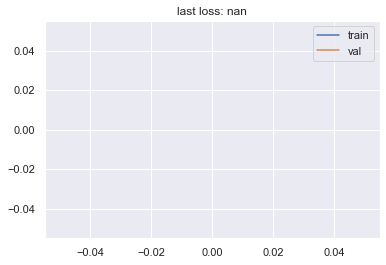

In [1]:
__author__ = "Puri Phakmongkol"
__author_email__ = "me@puri.in.th"

"""
* HII Operation Script
*
* Created date : 09/07/2022
*
+      o     +              o
    +             o     +       +
o          +
    o  +           +        +
+        o     o       +        o
-_-_-_-_-_-_-_,------,      o
_-_-_-_-_-_-_-|   /\_/\
-_-_-_-_-_-_-~|__( ^ .^)  +     +
_-_-_-_-_-_-_-""  ""
+      o         o   +       o
    +         +
o      o  _-_-_-_- Station Modeling
    o           +
+      +     o        o      +
""" 

import pandas as pd
import numpy as np

# %config InlineBackend.figure_format = 'svg'

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(6, 4)})
sns.set(rc={'figure.dpi': 230})

import yaml
from yaml.loader import SafeLoader

from pathlib import Path
import datetime
import os
import json

import tensorflow as tf

from sklearn.preprocessing import StandardScaler
import pickle
from scipy.stats import pearsonr

config = yaml.load(
    open('config.yml', 'r').read(),
    Loader=SafeLoader
)

print(config)

project_path = config['project_path']
latest_indices_update = config['last_update']

time_now = datetime.datetime.now()
date_path = time_now.isoformat().split('T')[0]

num_to_month = {
    1: 'JAN',
    2: 'FEB',
    3: 'MAR',
    4: 'APR',
    5: 'MAY',
    6: 'JUN',
    7: 'JUL',
    8: 'AUG',
    9: 'SEP',
    10: 'OCT',
    11: 'NOV',
    12: 'DEC'
}

def find_rbias(prediction, groundtruth) :
    return (np.sum(prediction-groundtruth)/np.sum(groundtruth)) * 100

"""
* Station Prediction Model
https://colab.research.google.com/drive/1C_UI_AyyRtdFYSMAxT8vFgzTyBYpRIWl#scrollTo=G-6iy_9ol21N
"""
def build_model() :
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape=(12, 6)))
    model.add(tf.keras.layers.GRU(64, return_sequences=False))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(12))

    return model

if __name__ == '__main__' :
    """
    * Load Station Data
    """
    station_all_df = pd.read_csv(f'{project_path}/data/static/tmd_station.csv')
    
    """
    * Load SimIDX Plus data
    """
    if config['simidx_last_update'] == '' or config['simidx_last_update'] == None or 'simidx_last_update' not in config :
        print('There are no indices data')
        exit()
    
    s_selected_columns = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV','DEC']
    group_result_filtered = json.loads(open(Path(project_path) / 'output' / config['simidx_last_update'] / 'simidx_plus' / 'result_filter.json', 'r').read())
    group_result_filtered = { int(k): v for k, v in group_result_filtered.items() }
    
    s_df = pd.read_csv(Path(project_path) / 'output' / config['simidx_last_update'] / 'simidx_plus' / 's_df.csv')
    s_df = s_df.dropna()

    """
    * Station Modeling
    """
    if not Path(f'{project_path}output/{date_path}').exists() :
        os.mkdir(Path(f'{project_path}output/{date_path}'))
        
    if not Path(f'{project_path}output/{date_path}/station_model').exists() :
        os.mkdir(Path(f'{project_path}output/{date_path}/station_model'))

    b_selected_columns = ['JANp', 'FEBp',
       'MARp', 'APRp', 'MAYp', 'JUNp', 'JULp', 'AUGp', 'SEPp', 'OCTp', 'NOVp',
       'DECp']

    basin_result = []
    validate_to = -3

    for basin in [ _ for _ in station_all_df.columns if _ not in ['Unnamed: 0', 'datetime', 'year', 'month'] ][:1] :
        if not Path(f'{project_path}output/{date_path}/station_model/{basin}').exists() :
            os.mkdir(Path(f'{project_path}output/{date_path}/station_model/{basin}'))

        station_result_path = Path(f'{project_path}output/{date_path}/station_model/{basin}')

        basin_df = station_all_df[['year', 'month', basin]]
        basin_df['month_eng'] = basin_df['month'].apply(lambda _ : num_to_month[_])
        basin_df_piv = basin_df.pivot(index='year', columns='month_eng')[basin]
        basin_df_piv = basin_df_piv[num_to_month.values()]
        basin_df_piv['annual_rainfall'] = basin_df_piv.apply(np.sum, axis=1)
        basin_df_piv = basin_df_piv.reset_index()
        basin_df_piv['th_year'] = basin_df_piv['year'] + 543
        # print(basin_df_piv)
        # basin_model_df_s = basin_df_piv.iloc[12:-2, :]
        basin_model_df_s = basin_df_piv.join(s_df[['f_thyear', 'label_th']].set_index('f_thyear'), on='th_year', how='inner')
        basin_model_df_s = basin_model_df_s.fillna(0)
        print('basin = ',basin)
        # print(basin_model_df_s.info())
        X_allrainfall = s_df[s_selected_columns]
        y_basinrainfall = basin_model_df_s[s_selected_columns]
        print(y_basinrainfall)

        # print(s_df.shape, basin_model_df_s.shape)

        ts_df = s_df.copy()
        ts_df['f_thyear_pair'] = ts_df['f_thyear'].apply(lambda _: group_result_filtered[_])
        ts_df = ts_df.join(basin_model_df_s.set_index('th_year'), 'f_thyear_pair', rsuffix='p')
        ts_df.to_pickle(station_result_path / 'ts_df.bin')
        # ts_df.to_pickle(f'{param_project_path}%s_station_%s_tsdf.bin'%(param_training_name, basin))

        X_station_pair = ts_df[b_selected_columns]

        train_year = s_df['f_thyear'].iloc[:validate_to]
        validate_year = s_df['f_thyear'].iloc[validate_to:]

        overall_scaler = StandardScaler()
        X_allrainfall_train = X_allrainfall.iloc[:validate_to, :]
        X_allrainfall_validate = X_allrainfall.iloc[validate_to:, :]
        X_allrainfall_i_train = overall_scaler.fit_transform(X_allrainfall_train)
        X_allrainfall_i_validate = overall_scaler.transform(X_allrainfall_validate)

        station_pair_scaler = StandardScaler()
        X_station_pair_train = X_station_pair.iloc[:validate_to, :]
        X_station_pair_validate = X_station_pair.iloc[validate_to:, :]
        X_station_pair_i_train = station_pair_scaler.fit_transform(X_station_pair_train)
        X_station_pair_i_validate = station_pair_scaler.transform(X_station_pair_validate)

        iod_u_df = s_df[['iod_l01', 'iod_l02', 'iod_l03', 'iod_l04', 'iod_l05',
        'iod_l06', 'iod_l07', 'iod_l08', 'iod_l09', 'iod_l10', 'iod_l11',
        'iod_l12']]
        pdo_u_df = s_df[['pdo_l01', 'pdo_l02', 'pdo_l03', 'pdo_l04', 'pdo_l05',
        'pdo_l06', 'pdo_l07', 'pdo_l08', 'pdo_l09', 'pdo_l10', 'pdo_l11',
        'pdo_l12']]
        oni_u_df = s_df[['oni_l01', 'oni_l02', 'oni_l03', 'oni_l04', 'oni_l05',
        'oni_l06', 'oni_l07', 'oni_l08', 'oni_l09', 'oni_l10', 'oni_l11',
        'oni_l12']]
        emi_u_df = s_df[['emi_l01', 'emi_l02', 'emi_l03', 'emi_l04', 'emi_l05',
        'emi_l06', 'emi_l07', 'emi_l08', 'emi_l09', 'emi_l10', 'emi_l11',
        'emi_l12']]

        X_train = np.stack([iod_u_df.iloc[:validate_to, :].values, 
            pdo_u_df.iloc[:validate_to, :].values,
            oni_u_df.iloc[:validate_to, :].values,
            emi_u_df.iloc[:validate_to, :].values,
            X_allrainfall_i_train,
            X_station_pair_i_train
            ], axis=-1)
        
        X_validate = np.stack([iod_u_df.iloc[validate_to:, :].values, 
            pdo_u_df.iloc[validate_to:, :].values,
            oni_u_df.iloc[validate_to:, :].values,
            emi_u_df.iloc[validate_to:, :].values,
            X_allrainfall_i_validate,
            X_station_pair_i_validate
            ], axis=-1)
        
        y_scaler = StandardScaler()
        y_basinrainfall_train = y_basinrainfall.iloc[:validate_to, :]
        y_basinrainfall_validate = y_basinrainfall.iloc[validate_to:, :]
        
        y_basinrainfall_i_train = y_scaler.fit_transform(y_basinrainfall_train)
        y_basinrainfall_i_validate = y_scaler.transform(y_basinrainfall_validate)

        scaler_list = {
            'overall' : overall_scaler,
            'y' : y_scaler,
            'station_pair' : station_pair_scaler,
        }

        pickle.dump(scaler_list, open(station_result_path / 'station_scaler.bin', 'wb'))

        model = build_model()
        model.compile(loss=tf.keras.losses.MeanSquaredError(), 
                optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4))

        print(X_train.shape, y_basinrainfall_i_train.reshape(-1, 12, 1).shape)

        history = model.fit(
            X_train, y_basinrainfall_i_train.reshape(-1, 12),
            epochs=500,
            batch_size=8,
            validation_data=(X_validate, y_basinrainfall_i_validate.reshape(-1, 12)),
            callbacks=[
                tf.keras.callbacks.ModelCheckpoint(station_result_path / 'station_model.bin', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True),
                tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.5),
                tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 60),
                # WandbCallback()
            ],
        )
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='val')
        plt.legend()
        plt.title('last loss: ' + str(model.history.history['loss'][-1]))
        plt.savefig(station_result_path / 'station_model_loss.png', format='png')

        print('----------')

    """
    * End Modeling
    """

In [18]:
ts_df[['year', 'f_thyear', 'annual_rainfall']]

,year,f_thyear,annual_rainfall
0,1981,2525,1379.0
1,1982,2526,1508.0
2,1983,2527,1406.0
3,1984,2528,1450.0
4,1985,2529,1411.0
5,1986,2530,1372.0
6,1987,2531,1570.0
7,1988,2532,1300.0
8,1989,2533,1438.0
9,1990,2534,1329.0


In [20]:
basin_model_df_s.join(ts_df[['f_thyear', 'annual_rainfall']].set_index('f_thyear'), on='th_year', rsuffix='x').dropna()

,year,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,annual_rainfall,th_year,label_th,annual_rainfallx
12,1982,1.900000,0.000000,0.000000,31.200001,178.600006,155.800003,111.199997,232.789993,209.699997,80.699997,23.400000,0.000000,1025.289994,2525,2525,1379.0
13,1983,0.100000,0.000000,0.000000,30.600000,44.200001,166.500000,109.500000,275.399994,231.699997,156.800003,73.699997,8.600000,1097.099992,2526,2526,1508.0
14,1984,0.000000,9.500000,0.000000,196.690002,128.300003,288.790009,250.389999,292.690002,143.199997,97.300003,0.500000,0.000000,1407.360016,2527,2527,1406.0
15,1985,0.000000,0.000000,0.000000,130.199997,158.899994,157.000000,182.500000,290.790009,184.000000,126.500000,112.599998,0.000000,1342.489998,2528,2528,1450.0
16,1986,0.000000,0.000000,0.800000,65.800003,198.100006,192.199997,188.399994,250.789993,150.600006,70.099998,20.900000,116.699997,1254.389994,2529,2529,1411.0
17,1987,14.300000,0.000000,20.299999,84.500000,70.800003,99.500000,209.589996,227.410004,161.100006,60.099998,116.000000,0.000000,1063.600007,2530,2530,1372.0
18,1988,0.000000,4.410000,0.000000,25.600000,223.399994,321.700012,262.190002,141.600006,75.000000,195.399994,73.300003,0.000000,1322.600012,2531,2531,1570.0
19,1989,4.200000,0.000000,0.100000,12.000000,146.500000,170.600006,240.699997,152.699997,123.800003,195.199997,16.799999,0.000000,1062.599999,2532,2532,1300.0
20,1990,0.000000,14.100000,3.300000,12.000000,386.290009,223.990005,228.490005,173.100006,127.099998,60.700001,27.700001,0.000000,1256.770026,2533,2533,1438.0
21,1991,3.500000,0.000000,0.000000,66.800003,134.000000,290.489990,125.900002,274.700012,276.989990,89.099998,188.089996,30.900000,1480.469992,2534,2534,1329.0


In [7]:
ts_df = ts_df.dropna()

In [9]:
ts_df['label_thp'] = ts_df['label_thp'].astype(int)

/var/folders/ly/nrjm8l7d73sc1pf_66s30v2r0000gn/T/ipykernel_5781/401059389.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts_df['label_thp'] = ts_df['label_thp'].astype(int)


0     2525
1     2526
2     2527
3     2528
4     2529
5     2530
6     2531
7     2532
8     2533
9     2534
10    2535
11    2536
12    2537
13    2538
14    2539
15    2540
16    2541
17    2542
18    2543
19    2544
20    2545
21    2546
22    2547
23    2548
24    2549
28    2553
29    2554
30    2555
31    2556
32    2557
33    2558
34    2559
35    2560
36    2561
Name: f_thyear, dtype: int64